In [1]:
from copy import deepcopy
from Udep2Mono.util import btree2list
from Udep2Mono.dependency_parse import tokenizer
from Udep2Mono.dependency_parse import dependency_parse
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline

from sentence_transformers import SentenceTransformer, util
sentenceTransformer = SentenceTransformer("roberta-large-nli-stsb-mean-tokens")

2021-03-13 00:04:47 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/gum.pt |
| depparse  | ../model/e...rse/gum.pt  |

2021-03-13 00:04:47 INFO: Use device: gpu
2021-03-13 00:04:47 INFO: Loading: tokenize
2021-03-13 00:04:48 INFO: Loading: pos
2021-03-13 00:04:49 INFO: Loading: lemma
2021-03-13 00:04:49 INFO: Loading: depparse
2021-03-13 00:04:49 INFO: Done loading processors!
2021-03-13 00:04:49 INFO: Loading these models for language: en (English):
| Processor | Package                 |
---------------------------------------
| tokenize  | ../model/e...ize/gum.pt |

2021-03-13 00:04:49 INFO: Use device: cpu
2021-03-13 00:04:49 INFO: Loading: tokenize
2021-03-13 00:04:49 INFO: Done loading processors!


In [2]:
import os
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

In [16]:
def inference_sts(seq1s, seq2s):
    embeddings1 = sentenceTransformer.encode(seq1s, convert_to_tensor=True)
    embeddings2 = sentenceTransformer.encode(seq2s, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    return cosine_scores[0][0]

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

roberta_MRPC = "textattack/roberta-base-MRPC"
bert_MRPC = "bert-base-cased-finetuned-mrpc"

paraphraseTokenizer = AutoTokenizer.from_pretrained(roberta_MRPC)  
paraphraseModel = AutoModelForSequenceClassification.from_pretrained(roberta_MRPC)

Some weights of the model checkpoint at textattack/roberta-base-MRPC were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
from chunker import Chunker

class SyntacticVariator:
    
    def __init__(self):
        self.chunker = Chunker()
        self.paraphraseTokenizer = paraphraseTokenizer
        self.paraphraseModel = paraphraseModel

    def chunking(self, tree):
        return self.chunker.get_chunks_byDepTree(tree)

    def build_pairs(self, chunks1, chunks2):
        chunk_pairs = []
        for chunk1 in chunks1:
            for chunk2 in chunks2:
                if len(set(chunk1.split(' ')).intersection(chunk2.split(' '))) > 0:
                     chunk_pairs.append((chunk1, chunk2))

        return chunk_pairs

    def inference_mrpc(self, seq1, seq2):
        paraphrase = paraphraseTokenizer.encode_plus(
            seq1, seq2, return_tensors="pt")
        logits = paraphraseModel(**paraphrase)[0]
        paraphrase_results = torch.softmax(logits, dim=1).tolist()[0]
        return paraphrase_results[1]

    def phrase_alignment(self, chunk_pairs):
        alignments = []
        for pair in chunk_pairs:
            score = self.inference_mrpc(pair[0], pair[1])
            print(pair, score)
            if score > 0.85:
                alignments.append(pair)

        return alignments

    def variate(self, sentence, p_tree, h_tree):
        p_chunks = self.chunking(p_tree)
        h_chunks = self.chunking(h_tree)

        chunk_pairs = self.build_pairs(p_chunks, h_chunks)
        alignments = self.phrase_alignment(chunk_pairs)

        var_sentence = copy(sentence)
        for align in alignments:
            var_sentence = var_sentence.replace(align[0], align[1])

        return var_sentence

In [31]:
premise = "Tom does not take criticism well"
hypothesis = "Tom does not take any different opinion well"

pipeline = PolarizationPipeline()
syntacticVariator = SyntacticVariator()

h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
pipeline.modify_replacement(h_tree, replaced)
annotation = pipeline.single_polarization(premise)

variate = syntacticVariator.variate(premise, annotation['polarized_tree'], h_tree)
similarity = inference_sts([variate], [hypothesis])
print(variate, similarity)

('not take', 'not take') 0.9298083186149597
('not take', 'not take any different opinion') 0.059350091964006424
('not take criticism', 'not take') 0.5380662083625793
('not take criticism', 'not take any different opinion') 0.2235867828130722
Tom does not take criticism well tensor(0.6538)


In [20]:
from pattern.en import pluralize, singularize
from copy import copy
import re
import torch

class PhrasalGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.original = None
        self.kb = {}
        self.hypothesis = ""
        self.tree_log = []
        self.sent_log = []
        self.stop_critarion = False
        self.mod_at_left = [
            "advmod", "amod", "advmod:count", 
            "acl:relcl", "obl", 'obl:npmod', 
            "obl:tmod", "nmod", "nmod:npmod", 
            "nmod:poss", "nmod:tmod", "obl:npmod",
            "acl", "advcl", "xcomp", "ccomp", 
            "appos", 'compound:ptr']
        self.mod_at_right = []
        self.mod_symmetric = ["conj", "compound"]
        
        '''  
            "cop": self.generate_inherite, 
            "expl": self.generate_expl,
            "nummod": self.generate_nummod,
        '''

    def deptree_generate(self, tree, annotated, original):
        self.stop_critarion = False
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree.copy()
        self.original = original  
        self.annotated = deepcopy(annotated)
        self.sentence = original
        self.generate(self.deptree)

    def generate(self, tree):
        if self.stop_critarion:
            return
        if not tree.is_tree:
            self.generate_default(tree)
        else:
            generation = self.get_generation_type(tree)
            generation(tree)

    def get_generation_type(self, tree):
        disjunction = False
        if tree.val == "conj":
            disjunction |= self.search_dependency('or', tree.left)
            disjunction |= self.search_dependency('and', tree.left)
        
        left_mod = tree.left.mark == "+"
        left_mod = left_mod or tree.left.mark == "=" or disjunction
        left_mod = left_mod and tree.val in self.mod_at_left

        right_mod = tree.right.mark == "+" or tree.right.mark == "="
        right_mod = right_mod or disjunction 

        sym_mod = tree.val in self.mod_symmetric and left_mod and right_mod

        if left_mod:
            return self.left_modifier_generate
        elif sym_mod:
            return self.symmetric_generate
        else:
            return self.generate_default

    def delete_cc(self, tree):
        if tree.val == "cc" and tree.left.val != "but":
            self.delete_modifier(tree, tree.right)

        if tree.is_tree:
            self.delete_cc(tree.left)
            self.delete_cc(tree.right)

    def delete_modifier(self, tree, modifier):
        tree.val = modifier.val
        tree.mark = modifier.mark
        tree.pos = modifier.pos
        tree.id = modifier.id
        
        tree.is_tree = modifier.is_tree
        tree.is_root = modifier.is_root

        tree.left = modifier.left
        tree.right = modifier.right

        self.delete_cc(tree)
        self.save_tree()

    def delete_left_modifier(self, tree):
        self.delete_modifier(tree, tree.right)

    def delete_right_modifier(self, tree):
        self.delete_modifier(tree, tree.left)

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.pos = backup.pos
        tree.id = backup.id
        tree.is_tree = backup.is_tree
        tree.is_root = backup.is_root

    def symmetric_generate(self, tree):
        self.right_modifier_generate(tree)
        self.left_modifier_generate(tree)
        self.delete_cc(tree)

    def right_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        self.delete_right_modifier(tree)
        self.save_tree()
        self.rollback(tree, backup)    
        
        self.generate(tree.left)
        self.generate(tree.right)

    def left_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        self.delete_left_modifier(tree)
        self.save_tree()
        self.rollback(tree, backup)   

        self.generate(tree.left)
        self.generate(tree.right)
    
    def return_last_leaf(self, tree):
        max_id = 0
        max_id_l = 0
        max_id_r = 0

        if tree.id != None:
            max_id = int(tree.id)
    
        if tree.left.is_tree:
            max_id_l = self.return_last_leaf(tree.left)
        else:
            max_id_l = tree.left.id

        if tree.right.is_tree:
            max_id_r = self.return_last_leaf(tree.right)
        else:
            max_id_r = tree.right.id

        return max(max_id, max(max_id_l, max_id_r))

    def return_first_leaf(self, tree):
        min_id = 100
        min_id_l = 100
        min_id_r = 100

        if tree.id != None:
            min_id = int(tree.id)
    
        if tree.left.is_tree:
            min_id_l = self.return_last_leaf(tree.left)
        else:
            min_id_l = tree.left.id

        if tree.right.is_tree:
            min_id_r = self.return_last_leaf(tree.right)
        else:
            min_id_r = tree.right.id

        return min(min_id, min(min_id_l, min_id_r))

    def add_modifier_sent(self, tree, modifier, direct=0): 
        sentence = deepcopy(self.sentence)
        if direct == 0:
            last_leaf = self.return_first_leaf(tree)
            sentence.insert(last_leaf-1, modifier)
        elif direct == 1:
            last_leaf = self.return_last_leaf(tree)
            sentence.insert(last_leaf, modifier)        

        self.remove_adjcent_duplicate(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.replace("-", " ")
        sentence = sentence.replace(" 's", "'s")

        if abs(len(sentence) - len(self.hypothesis)) < 15:
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip() 
            
            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 1.0))
                return
                
            similarity = inference_sts([sentence], [self.hypothesis])
            if similarity > 0.90:
                self.sent_log.append((sentence, similarity))
            if similarity > 0.97:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def add_modifier_lexical(self, tree, modifier, head, word_id, direct=0):
        if direct == 0:
            generated = ' '. join([modifier, head])
        else:
            generated = ' '. join([head, modifier])
        
        sentence = deepcopy(self.sentence)
        diff = 0
        if word_id > len(sentence):
            diff = word_id - len(sentence)

        goal = word_id-1-diff
        sentence[goal] = "DEL"
        sentence[goal:goal] = generated.split(' ')

        if abs(len(sentence) - len(self.hypothesis.split(' '))) < 7:
            self.remove_adjcent_duplicate(sentence)
            sentence = ' '.join(sentence)
            sentence = sentence.replace("DEL ", "")
            sentence = sentence.replace("DEL", "")
            sentence = sentence.replace("-", " ")
            sentence = sentence.replace(" 's", "'s")
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip()

            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 1.0))
                return
            
            similarity = inference_sts([sentence], [self.hypothesis])
            if similarity > 0.9:
                self.sent_log.append((sentence, similarity))
            if similarity > 0.97:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def generate_default(self, tree):
        VP_rel = {
            "aux":1, 
            "obj":1, 
            "obl":1, 
            "xcomp":1, 
            "ccomp":1,
            "aux:pass":1, 
            "obl:tmod":1, 
            "obl:npmod":1
        }

        VP_mod = {
            "advcl":1, 
            "xcomp":1, 
            "ccomp":1,
            "obj":1, 
            "advmod":1, 
            "obl":1, 
            "obl:tmod":1,
            "obl:nmod":1, 
            "parataxis":1, 
            "conj":1
        }

        NP_rel = {
            "amod":1,
            "compound":1,
            "det":1,
            "mark":1,
            "nmod:poss":1,
            "flat":1,
            "acl:relcl":1,
            "acl":1,
            "nmod":1
        }

        NP_mod = {
            "amod":1,
            "compound":1,
            "det":1,
            "mark":1,
            "nmod:poss":1,
            "flat":1,
        }

        if tree.pos is not None:
            if ("NN" in tree.pos or "JJ" in tree.pos) and tree.mark == "-":
                for rel in ["amod", "compound", "det", "mark", "nmod:poss", "flat", "conj", "nummod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            if phrase['head'] == tree.val:
                                self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                for rel in ["amod", "acl:relcl", "compound", "acl", "nmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            if phrase['head'] == tree.val:
                                self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)
                
            elif "VB" in tree.pos and tree.mark == "-":
                for rel in ["advmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)

        elif VP_rel.get(tree.val, 0) and tree.mark == "-":
            for rel in VP_mod:
                if rel in self.kb:
                    for phrase in self.kb[rel]:
                        self.add_modifier_sent(tree, phrase['mod'], direct=1)

        elif NP_rel.get(tree.val, 0) and tree.mark == "-":
            for rel in NP_mod:
                if rel in self.kb:
                    for phrase in self.kb[rel]:
                        self.add_modifier_sent(tree, phrase['mod'], direct=0)

        if tree.is_tree:
            self.generate(tree.left)
            self.generate(tree.right)  

    def save_tree(self):
        leaves = self.deptree.sorted_leaves().popkeys()
        sentence = ' '.join([x[0] for x in leaves])

        if sentence.lower() == self.hypothesis.lower():
            self.tree_log = []
            self.stop_critarion = True
            self.tree_log.append((self.deptree.copy(), sentence, 1.0))
            return
        
        similarity = inference_sts([sentence], [self.hypothesis])
        if similarity > 0.9:
            self.tree_log.append((self.deptree.copy(), sentence, similarity))
        if similarity > 0.97:
            self.tree_log = []
            self.tree_log.append((self.deptree.copy(), sentence, similarity))
            self.stop_critarion = True
    
    def remove_adjcent_duplicate(self, string):
        to_remove = -1
        for i in range(len(string)-1):
            if string[i] == string[i+1]:
                to_remove = i
        if to_remove > -1:
            del string[to_remove]

    def search_dependency(self, deprel, tree):
        if tree.val == deprel:
            return True
        else:
            right = tree.right
            left = tree.left

            left_found = False
            right_found = False

            if right is not None:
                right_found = self.search_dependency(deprel, right)

            if left is not None:
                left_found = self.search_dependency(deprel, left)

            return left_found or right_found
    
    def Diff(self, li1, li2):
        return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))    
    
    def preprocess(self, sentence):
        preprocessed = sentence.replace(".", "").replace("!", "").replace("?", "")
        preprocessed = preprocessed.replace("can't", "can not")
        preprocessed = preprocessed.replace("couldn't", "could not")
        preprocessed = preprocessed.replace("don't", "do not")
        preprocessed = preprocessed.replace("doesn't", "does not")
        preprocessed = preprocessed.replace("isn't", "is not")
        preprocessed = preprocessed.replace("won't", "will not")
        preprocessed = preprocessed.replace("wasn't", "was not")
        preprocessed = preprocessed.replace("weren't", "were not")
        preprocessed = preprocessed.replace("didn't", "did not")
        preprocessed = preprocessed.replace("aren't", "are not")
        preprocessed = preprocessed.replace("it's", "it is")
        preprocessed = preprocessed.replace("wouldn't", "would not")
        preprocessed = preprocessed.replace("There's", "There is")
        return preprocessed

In [18]:
modifier_relation = {
    "NN": ["amod", "nmod", "acl:relcl", "fixed", "compound", "det", "nmod:poss", "conj", "nummod"],
    "VB": ["advmod", "acl", "obl", "xcomp", "advcl", "obl:tmod", "parataxis", "obj","ccomp"]
}

def down_right(tree):
    if(tree.right == None):
        return tree
    return down_right(tree.right)

def down_left(tree):
    if(tree.left == None):
        return tree
    return down_left(tree.left)

def collect_modifiers(tree, sent_set, mod_type="NN"):
    leaves = []
    if tree.is_tree:
        if tree.val in ["mark", "case", "compound", "flat"]:
            leaves.append(
                (list(tree.right.sorted_leaves().popkeys()),
                down_right(tree.left).val)
            )
        if tree.val in modifier_relation[mod_type]:
            leaves.append(
                (list(tree.left.sorted_leaves().popkeys()),
                down_right(tree.right).val)
            )

        for leave in leaves:
            if len(leave) > 0 and len(leave) < 10:
                head = leave[1]
                modifier = ' '.join([x[0] for x in leave[0]])
                if tree.val in sent_set:
                    sent_set[tree.val].append({'head': head,'mod': modifier})
                else:
                    sent_set[tree.val] = [{'head': head,'mod': modifier}]
        
        collect_modifiers(tree.left, sent_set, mod_type)
        collect_modifiers(tree.right, sent_set, mod_type)

In [6]:
MED_upward = []
MED_upward_hypo = []
MED_downward = []
MED_downward_hypo = []

with open("../data/MED/upward.txt") as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 4):
        MED_upward.append(lines[i*4+1])
        MED_upward_hypo.append(lines[i*4+2])

with open("../data/MED/downward.txt") as donward_med:
    lines = donward_med.readlines()
    for i in range(len(lines) // 4):
        MED_downward.append(lines[i*4+1])
        MED_downward_hypo.append(lines[i*4+2])



Init Premise: I do not want to have children

Hypothesis: I do not want to have four children
{   'advmod': [{'head': 'want', 'mod': 'not'}],
    'mark': [   {'head': 'to', 'mod': 'have four children'},
                {'head': 'to', 'mod': 'have four children'}],
    'nummod': [{'head': 'children', 'mod': 'four'}],
    'obj': [{'head': 'have', 'mod': 'four children'}],
    'xcomp': [{'head': 'want', 'mod': 'to have four children'}]}


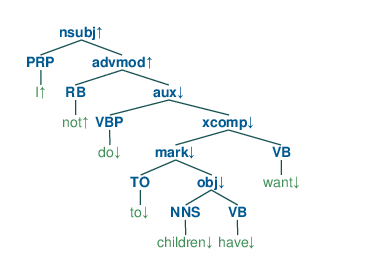

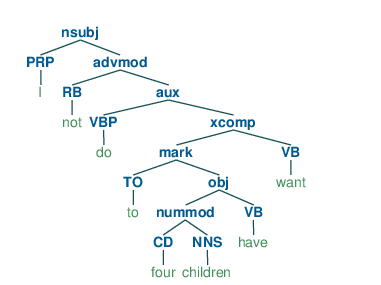

('I do not want to have children four children', tensor(0.9622))
('I do not want to have children four children', tensor(0.9622))
('I do not want to have children four children', tensor(0.9622))
('I do not want to have four children', 1.0)
True


In [21]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

up = ["I do not want to have children"]
up_h = ["I do not want to have four children"]

annotations = []
phrasalGenerator = PhrasalGenerator()
pipeline = PolarizationPipeline(verbose=0)
for i in range(len(up)):
    premise = up[i]
    hypothesis = up_h[i]
    premise = phrasalGenerator.preprocess(premise)
    hypothesis = phrasalGenerator.preprocess(hypothesis)

    tokenized = tokenizer(premise).sentences[0].words
    tokens = [tok.text for tok in tokenized]

    print("\n====================================")
    print("\nInit Premise: " + premise)
    print("\nHypothesis: " + hypothesis)

    h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
    h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
    pipeline.modify_replacement(h_tree, replaced)
    phrases = {} 
    collect_modifiers(h_tree, phrases, mod_type="NN")
    collect_modifiers(h_tree, phrases, mod_type="VB")
    annotation = pipeline.single_polarization(premise)
    
    phrasalGenerator.kb = phrases
    phrasalGenerator.hypothesis = hypothesis.replace(',', '')
    pp.pprint(phrasalGenerator.kb)
    
    polarized = pipeline.postprocess(annotation['polarized_tree'], {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz) 

    polarized = pipeline.postprocess(h_tree, {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz)
    
    phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], 
        annotation['annotated'], tokens)

    for gen_tree in phrasalGenerator.tree_log:
        #leaves = gen_tree[0].sorted_leaves().popkeys()
        #sentence = ' '.join([x[0] for x in leaves])
        print((gen_tree[1], gen_tree[2]))

    print(*phrasalGenerator.sent_log, sep="\n")
    print(phrasalGenerator.stop_critarion)

In [13]:
from tqdm import tqdm

annotations = []
with open("./generation_log_donward.txt", 'w') as generate_log:
    phrasalGenerator = PhrasalGenerator()
    pipeline = PolarizationPipeline(verbose=0)
    for i in tqdm(range(1200, 1400)):
        premise = MED_downward[i].replace('\n', '')
        hypothesis = MED_downward_hypo[i].replace('\n', '')
        premise = phrasalGenerator.preprocess(premise)
        hypothesis = phrasalGenerator.preprocess(hypothesis)

        tokenized = tokenizer(premise).sentences[0].words
        tokens = [tok.text for tok in tokenized]

        try:
            h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
            h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
        except:
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            continue
        pipeline.modify_replacement(h_tree, replaced)
        phrases = {} 
        collect_modifiers(h_tree, phrases, mod_type="NN")
        collect_modifiers(h_tree, phrases, mod_type="VB")

        try:
            annotation = pipeline.single_polarization(premise)
        except:
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            continue
    
        phrasalGenerator.kb = phrases
        #print(phrasalGenerator.kb)
        phrasalGenerator.hypothesis = hypothesis.replace(',', '')
        
        phrasalGenerator.deptree_generate(
            annotation['polarized_tree'], 
            annotation['annotated'], 
            tokens)

        for gen_tree in phrasalGenerator.tree_log:
            leaves = gen_tree[0].sorted_leaves().popkeys()
            sentence = ' '.join([x[0] for x in leaves])
            print((sentence, gen_tree[1]))
            
        if not phrasalGenerator.stop_critarion:
            generate_log.write("\nID: " + str(i))
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            #print("\nPremise: " + premise)
            #print("\nHypothesis: " + hypothesis)
            #print(*phrasalGenerator.sent_log, sep="\n")
            #generate_log.writelines(phrasalGenerator.sent_log)
            generate_log.write('\n')

 82%|████████▏ | 164/200 [01:06<00:12,  2.93it/s]('He prefers to drink coffee without sugar or milk', 'He prefers to drink coffee without sugar or milk')
('He prefers to drink coffee without sugar or milk', 'He prefers to drink coffee without sugar or milk')
 88%|████████▊ | 177/200 [01:11<00:09,  2.46it/s]('No joker should be without a whoopee cushion', 'No joker should be without a whoopee cushion')
('No joker should be without a whoopee cushion', 'No joker should be without a whoopee cushion')
 96%|█████████▌| 191/200 [01:16<00:03,  2.73it/s]('The villagers have done without electricity for a time', 'The villagers have done without electricity for a time')
('The villagers have done without electricity for a time', 'The villagers have done without electricity for a time')
100%|██████████| 200/200 [01:19<00:00,  2.50it/s]


In [ ]:
sentences = ["Some red flowers need light", 
             "Some red and beautiful flowers need light",
             "All flowers need light and water", 
             "No flowers need bright or warm light",
             "John can sing and dance",
             "John ate an apple and finished his homework",
             "John finished his homework and did not eat an apple"]

upward = ["Some students sing to celebrate their graduation",
          "An Irishman won the nobel prize for literature.",
          "A big poison spider was spanning a web", 
          "A Californian special policeman pulled a car over and spoke to the driver",
          "A woman is dancing in a cage", 
          "A woman is dancing beautifully in a cage", 
          "People are riding and paddling a raft", 
          "Some delegates finished the survey on time"]

sick_upward = ["A brown dog is attacking another animal in front of the tall man in pants",
               "A skilled person is riding a bicycle on one wheel",
               "Two children are lying in the snow and are drawing angels"]

downward = ["No spider was spanning a web",
            "No student finished homework",
            "I've never flown in an airplane"]

hypothesis = ["No poison spider was spanning a web", 
              "No student at school finished homework compeletly",
              "I've never flown in an airplane because i'm afraid."] 